In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing as prp
from pandas.api.types import is_numeric_dtype

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

import spotipy
from spotipy.oauth2 import SpotifyOAuth
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
import sys
import pprint
import os


In [ ]:
# pip install spotipy

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Music_Recommender/Kaggle/Spotify_Tracks_Dataset/useful_feature.csv')

In [ ]:
# songs_df = pd.read_csv('/content/drive/MyDrive/Music_Recommender/Kaggle/Spotify_Tracks_Dataset/complete_feature.csv')

In [ ]:
complete_feature_set = pd.read_csv('/content/drive/MyDrive/Music_Recommender/Kaggle/Spotify_Tracks_Dataset/complete_feature.csv')

In [ ]:
# songs_df.describe()

# Connect to Spotify API

In [ ]:
# pip install spotipy --upgrade


In [ ]:
#client id and secret for my application



In [ ]:
scope = 'user-library-read'

auth_manager = SpotifyClientCredentials()
sp = spotipy.Spotify(auth_manager=auth_manager)

# Get audio features from spotify     

1. track_id	
2. artists	
3. track_genre	
4. mode	
5. key	
6. popularity	
7. danceability	
8. energy	
9. speechiness	
10. acousticness	
11. liveness	
12. valence	
13. tempo


# Features missing from audio_features

* popularity
* track_genre
* artist

In [ ]:
heyJude = 'spotify:track:1eT2CjXwFXNx6oY5ydvzKU'
track_feature = sp.audio_features(heyJude)

track_feature[0]['danceability']

0.462

In [ ]:

# artist_info = sp.artist(heyJude)
# uri = artist_info[0]['uri']

# artist_detail = sp.artist(uri)

# artist_genre = artist_detail['genres']
# artist_popularity = artist_detail['popularity']

# print(artist_genre)
# print(artist_popularity)

# Creating features for each track

In [ ]:
def extract_track_features(track_uri):
  track_features = sp.audio_features(track_uri)[0]
  remove_list = ['loudness', 'type', 'uri', 'track_href', 'analysis_url', 'duration_ms', 'time_signature']
  
  track_features = {k: v for k, v in track_features.items() if k not in remove_list}

  return track_features

In [ ]:
extract_track_features(heyJude)

{'danceability': 0.462,
 'energy': 0.632,
 'key': 5,
 'mode': 1,
 'speechiness': 0.0248,
 'acousticness': 0.091,
 'instrumentalness': 0,
 'liveness': 0.397,
 'valence': 0.585,
 'tempo': 74.268,
 'id': '1eT2CjXwFXNx6oY5ydvzKU'}

In [ ]:
uri = sp.track(heyJude)['artists'][0]['uri']
sp.artist(uri)['popularity']

84

In [ ]:
def extract_popularity_genre(track_uri):
  artist_uri = sp.track(track_uri)['artists'][0]['uri']
  artist_detail = sp.artist(artist_uri)

  artist_genre = artist_detail['genres']
  artist_popularity = artist_detail['popularity']

  #reformatiing each genre in the list
  for idx, x in enumerate(artist_genre):
    artist_genre[idx] = x.lower().replace(" ", "").replace("-", "").replace(".", "")

  dic = {'track_genres' : [artist_genre],
         'popularity' : artist_popularity}
  
  return dic


In [ ]:
extract_popularity_genre(heyJude)

{'track_genres': [['beatlesque',
   'britishinvasion',
   'classicrock',
   'merseybeat',
   'psychedelicrock',
   'rock']],
 'popularity': 84}

In [ ]:
def create_feature_for_track(track_uri):
  track_features = extract_track_features(track_uri)
  artist_features = extract_popularity_genre(track_uri)
  
  res_dic = artist_features | track_features
  # print(res_dic['energy'])
  return pd.DataFrame(res_dic)


In [ ]:
res_song_df = create_feature_for_track(heyJude)


In [ ]:
res_song_df

,track_genres,popularity,danceability,energy,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id
0,"[beatlesque, britishinvasion, classicrock, mer...",84,0.462,0.632,5,1,0.0248,0.091,0,0.397,0.585,74.268,1eT2CjXwFXNx6oY5ydvzKU


## Normalize

In [ ]:
def ohe_prep(df, column, new_name): 
    """ 
    Create One Hot Encoded features of a specific column

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        column (str): Column to be processed
        new_name (str): new column name to be used
        
    Returns: 
        tf_df: One hot encoded features 
    """
    
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df

In [ ]:
# One-hot Encoding
key_ohe = ohe_prep(res_song_df, 'key','key') * 0.5
mode_ohe = ohe_prep(res_song_df, 'mode','mode') * 0.5

In [ ]:
float_cols = res_song_df.dtypes[res_song_df.dtypes == 'float64'].index.values


In [ ]:
# Normalization


# Scale popularity columns
pop = res_song_df[['popularity']].reset_index(drop = True)
scaler = MinMaxScaler()
pop_scaled = pd.DataFrame(scaler.fit_transform(pop), columns = pop.columns) * 0.2 

# Scale audio columns
floats = res_song_df[float_cols].reset_index(drop = True)
scaler = MinMaxScaler()
floats_scaled = pd.DataFrame(scaler.fit_transform(floats), columns = floats.columns) * 0.2



In [ ]:
final_song_feature = pd.concat([key_ohe, mode_ohe, pop_scaled, floats_scaled], axis = 1)
final_song_feature['id'] = res_song_df['id'].values

In [ ]:
final_song_feature

,key|5,mode|1,popularity,danceability,energy,speechiness,acousticness,liveness,valence,tempo,id
0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1eT2CjXwFXNx6oY5ydvzKU


# Generate the playlist dataframe

In [ ]:
test_playlist_id = '37i9dQZF1EQnqst5TRi17F'

In [ ]:
def create_playlist_df_that_in_dataset(playlist_id, dataset):
  playlist = pd.DataFrame()

  for ix, i in enumerate(sp.playlist_tracks(playlist_id)['items']):
    playlist.loc[ix, 'artist'] = i['track']['artists'][0]['name']
    playlist.loc[ix, 'name'] = i['track']['name']
    playlist.loc[ix, 'track_id'] = i['track']['id'] # ['uri'].split(':')[2]
    # playlist.loc[ix, 'url'] = i['track']['album']['images'][1]['url']

  # playlist['date_added'] = pd.to_datetime(playlist['date_added'])

  playlist = playlist[playlist['track_id'].isin(dataset['track_id'].values)]

  return playlist

In [ ]:
playlist_in_df  = create_playlist_df_that_in_dataset(test_playlist_id, dataset)
playlist_in_df


,artist,name,track_id
3,The Notorious B.I.G.,Big Poppa - 2005 Remaster,2g8HN35AnVGIk7B8yMucww
4,Ice Cube,You Know How We Do It,2Ih217RCGAmyQR68Nn7Cqo
5,Dr. Dre,The Next Episode,4LwU4Vp6od3Sb08CsP99GC
7,Nas,The Message,1AHfovSnGPVYKaahRtA0U6
10,50 Cent,In Da Club,7iL6o9tox1zgHpKUfh9vuC
12,The Notorious B.I.G.,Juicy - 2005 Remaster,5ByAIlEEnxYdvpnezg7HTX
13,2Pac,Hit 'Em Up - Single Version,0Z2J91b2iTGLVTZC4fKgxf
14,Nas,If I Ruled the World (Imagine That) (feat. Lau...,5PQmSHzWnlgG4EBuIqjac2
15,Eminem,Stan,3UmaczJpikHgJFyBTAJVoz
16,Dr. Dre,Forgot About Dre,7iXF2W9vKmDoGAhlHdpyIa


# Generate Track Dataframe

In [ ]:
def create_track_df_that_in_dataset(track_id, dataset):
  track = pd.DataFrame()

  track['artist'] = sp.track(track_id)['artists'][0]['name']  
  track['name'] = sp.track(track_id)['name']
  track['track_id'] = track_id

  return track

# Generate Playlist Features

In [ ]:
complete_feature_set[complete_feature_set['track_id'].isin(playlist_in_df['track_id'].values)]

,genre|acoustic,genre|afrobeat,genre|alternative,genre|altrock,genre|ambient,genre|anime,genre|blackmetal,genre|bluegrass,genre|blues,genre|brazil,...,key|5,key|6,key|7,key|8,key|9,key|10,key|11,mode|0,mode|1,track_id
33520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5,503OTo2dSqe7qk76rgsbep
33521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5,0.0,4LwU4Vp6od3Sb08CsP99GC
33616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0Z2J91b2iTGLVTZC4fKgxf
33637,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5,0.0,2Ih217RCGAmyQR68Nn7Cqo
33651,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,5g9lS8deSIxItFBmZRC4vN
33654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.5,7iXF2W9vKmDoGAhlHdpyIa
33747,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,4AE7Lj39VnSZNOmGH2iZaq
33750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,1SWVDBtw6h3tm9OehOkDhv
42537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.5,7KwZNVEaqikRSBSpyhXK2j
42540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.5,0.0,2g8HN35AnVGIk7B8yMucww


In [ ]:
def generate_playlist_feature(complete_feature_set, playlist_in_df):
  #findings songs in playlist with their features
  complete_feature_set_playlist = complete_feature_set[complete_feature_set['track_id'].isin(playlist_in_df['track_id'].values)]
  # find non-playlist songs features
  complete_feature_set_nonplaylist = complete_feature_set[~complete_feature_set['track_id'].isin(playlist_in_df['track_id'].values)]
  complete_feature_set_playlist_final = complete_feature_set_playlist.drop(columns = "track_id")

  return complete_feature_set_playlist_final.sum(axis = 0), complete_feature_set_nonplaylist

In [ ]:
complete_feature_set_playlist_vector, complete_feature_set_nonplaylist = generate_playlist_feature(complete_feature_set, playlist_in_df)


# Generate Recommendation

In [ ]:
def generate_recommendation(dataset, playlist_vector, nonplaylist_features):
  #songs that are in dataset but not in playlist
  non_playlist_df = dataset[dataset['track_id'].isin(nonplaylist_features['track_id'].values)]

  # Find cosine similarity between the playlist and the complete song set
  non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('track_id', axis = 1).values, playlist_vector.values.reshape(1, -1))[:,0]

  return non_playlist_df.sort_values('sim',ascending = False)

In [ ]:
recommend = generate_recommendation(dataset,complete_feature_set_playlist_vector, complete_feature_set_nonplaylist)

<ipython-input-284-b3bade97b491>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('track_id', axis = 1).values, playlist_vector.values.reshape(1, -1))[:,0]


In [ ]:
recommend.head()


,track_id,artists,track_genre,mode,key,popularity,danceability,energy,speechiness,acousticness,liveness,valence,tempo,sim
43157,53oWwSxPuyH2cjYKXH8fgO,['juniormafia'],['hardcore'],0,11,62,0.736,0.828,0.284,0.4770,0.2510,0.899,91.224,0.801274
42635,1ozdRCYFVt8Ui0dba1520D,"['thenotoriousbig', 'bonethugsnharmony']",['hardcore'],0,11,60,0.738,0.782,0.169,0.1430,0.1760,0.654,154.875,0.799611
42722,6JI5wNWYdBw68GZjOMmgK5,['bigl'],['hardcore'],0,11,64,0.711,0.620,0.212,0.0175,0.1340,0.805,179.817,0.799041
42912,42qK1JWm8fDy3qHZbIZNuQ,['nas'],['hardcore'],0,11,61,0.865,0.595,0.227,0.0377,0.0877,0.819,96.948,0.798443
43204,2kM3gIkHRiikiaIUFk3Fje,['thenotoriousbig'],['hardcore'],0,11,55,0.824,0.730,0.247,0.2020,0.4420,0.625,91.743,0.798187


In [ ]:
sp.track('0KSOLEBixnBYIKNHF1VbzF')['album']['images'][0]['url']

'https://i.scdn.co/image/ab67616d0000b27371ef95ca0f8a1270a3cebc05'

# Storing top X in new DF

In [ ]:
def get_top_rec(recommend, top):
  res_df = recommend.head(top).copy()
  
  res_df['track_name'] = res_df['track_id'].apply(lambda x : sp.track(x)['name'])
  res_df['artist_name'] = res_df['track_id'].apply(lambda x : sp.track(x)['artists'][0]['name'])
  res_df['image_url'] = res_df['track_id'].apply(lambda x : sp.track(x)['album']['images'][0]['url'])

  return res_df

In [ ]:
res_recommended = get_top_rec(recommend, 5)

# Visualize Image

In [ ]:
from skimage import io
import matplotlib.pyplot as plt

def visualize_songs(df):
    """ 
    Visualize cover art of the songs in the inputted dataframe

    Parameters: 
        df (pandas dataframe): Playlist Dataframe
    """
    
    temp = df['image_url'].values
    plt.figure(figsize=(15,int(0.625 * len(temp))))
    num_columns = 5
    
    for i, url in enumerate(temp):
      num_rows = len(temp) / num_columns
      plt.subplot(int(num_rows), num_columns, i + 1)

      image = io.imread(url)
      plt.imshow(image)
      plt.xticks(color = 'w', fontsize = 0.1)
      plt.yticks(color = 'w', fontsize = 0.1)
      plt.xlabel(df['track_name'].values[i], fontsize = 12)
      plt.tight_layout(h_pad=0.4, w_pad=0)
      plt.subplots_adjust(wspace=None, hspace=None)

    plt.show()

In [ ]:
res_recommended['image_url'].values

array(['https://i.scdn.co/image/ab67616d0000b273bcb142272cf0b0033b88e5bb',
       'https://i.scdn.co/image/ab67616d0000b273639fea4197e676cfe9512e04',
       'https://i.scdn.co/image/ab67616d0000b273f22da4550a4de3cefb5afc0b',
       'https://i.scdn.co/image/ab67616d0000b273267e806f40829db77ac0827b',
       'https://i.scdn.co/image/ab67616d0000b273639fea4197e676cfe9512e04'],
      dtype=object)

<ipython-input-290-cc033231145d>:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(int(num_rows), num_columns, i + 1)


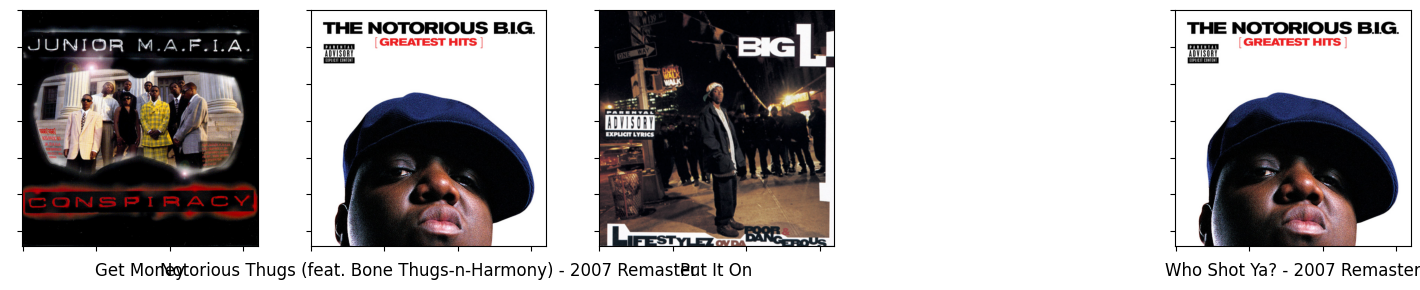

In [ ]:
visualize_songs(res_recommended)

# Playlist recommender

In [ ]:
playlist_id = '4dsLgcubxIzryC4Nk2wVyW'

playlist_in_df  = create_playlist_df_that_in_dataset(playlist_id, dataset)

complete_feature_set_playlist_vector, complete_feature_set_nonplaylist = generate_playlist_feature(complete_feature_set, playlist_in_df)

recommend = generate_recommendation(dataset,complete_feature_set_playlist_vector, complete_feature_set_nonplaylist)

res_recommended = get_top_rec(recommend, 6)
res_recommended

<ipython-input-284-b3bade97b491>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('track_id', axis = 1).values, playlist_vector.values.reshape(1, -1))[:,0]


,track_id,artists,track_genre,mode,key,popularity,danceability,energy,speechiness,acousticness,liveness,valence,tempo,sim,track_name,artist_name,image_url
45827,1n1b2lwdRdWF5RAaA0vewk,"['neerajshridhar', 'mastersaleem', 'suziq']",['hiphop'],0,1,58,0.780,0.904,0.2000,0.16300,0.0662,0.664,129.966,0.845101,Aahun Aahun,Neeraj Shridhar,https://i.scdn.co/image/ab67616d0000b273f2d8b1...
45187,1aL9518P5G72N92b48tuKw,['apdhillon'],['hiphop'],0,1,83,0.860,0.541,0.0325,0.16500,0.0663,0.952,114.984,0.844852,Summer High,AP Dhillon,https://i.scdn.co/image/ab67616d0000b273b0543b...
45193,7AsG1F1eMWd17RYan8M3Wm,"['apdhillon', 'shindakahlon']",['hiphop'],0,1,71,0.811,0.655,0.0353,0.09470,0.0680,0.925,117.979,0.844717,Dil Nu,AP Dhillon,https://i.scdn.co/image/ab67616d0000b2738471bf...
45301,6HGoVbCUr63SgU3TjxEVj6,['imrankhan'],['hiphop'],0,1,70,0.726,0.652,0.1100,0.00451,0.2260,0.803,163.879,0.844619,Satisfya,Imran Khan,https://i.scdn.co/image/ab67616d0000b273164d4a...
45444,455OjhLhU9JCNYKKoUOFwr,"['tegipannu', 'mannisandhu']",['hiphop'],0,1,64,0.720,0.711,0.0457,0.30900,0.4920,0.713,148.223,0.844439,Into You,Tegi Pannu,https://i.scdn.co/image/ab67616d0000b27321899c...
45682,1vSXwYeKnzsVvekSpqVabx,"['ajayatul', 'shreyaghoshal']",['hiphop'],0,1,62,0.693,0.956,0.0710,0.28900,0.2940,0.665,90.005,0.844291,Chikni Chameli,Ajay-Atul,https://i.scdn.co/image/ab67616d0000b273b22e21...


In [ ]:
def get_playlist_series():
  playlist_series = complete_feature_set[complete_feature_set['track_id'].isin(playlist_in_df['track_id'].values)]
  playlist_series = playlist_series[['danceability', 'energy',	'speechiness', 'acousticness', 'liveness',	'valence']]
  return playlist_series.mean(axis=0)

In [ ]:
def get_output_series():
  output_series = complete_feature_set[complete_feature_set['track_id'].isin(res_recommended['track_id'].values)]
  output_series = output_series[['danceability', 'energy',	'speechiness', 'acousticness', 'liveness',	'valence']]
  return output_series.mean(axis=0)

In [ ]:
def generate_graph():
  
  playlist_series = get_playlist_series()
  output_series = get_output_series()

  plt.plot(output_series, label='Output features', color='green')
  plt.plot(playlist_series,label='Input features', color='blue')
  plt.legend()
  plt.ylabel('Values', fontsize=10)
  plt.xlabel('Features', fontsize=10)

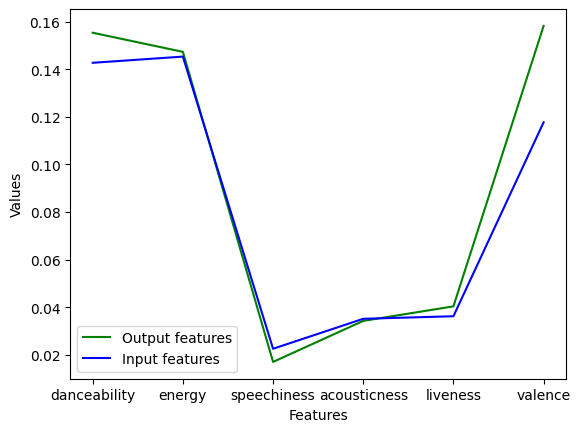

In [ ]:
generate_graph()

In [ ]:
"""
  This is Metallica - 37i9dQZF1DZ06evO1sJmec
  This is Slipknot - 5SCVdGXoAAtx81GjTNr71y
  This is Linkin Park - 37i9dQZF1DZ06evO47cwRq
  Punjabi porn - 4dsLgcubxIzryC4Nk2wVyW
"""

'\n  This is Metallica - 37i9dQZF1DZ06evO1sJmec\n  This is Slipknot - 5SCVdGXoAAtx81GjTNr71y\n  This is Linkin Park - 37i9dQZF1DZ06evO47cwRq\n  Punjabi porn - 4dsLgcubxIzryC4Nk2wVyW\n'

# Single track recommender

In [ ]:
# track_id = '7HtPBwBoCBDy1tpstag7HL'

# track_in_df  = create_track_df_that_in_dataset(track_id, dataset)

# track_in_df
# # complete_feature_set_track_vector, complete_feature_set_nontrack = generate_playlist_feature(complete_feature_set, track_in_df)

# # recommend = generate_recommendation(dataset,complete_feature_set_track_vector, complete_feature_set_nontrack)

# # res_recommended = get_top_rec(recommend, 5)
# # res_recommended
